In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
from scipy import signal

import warnings
warnings.simplefilter("ignore")

# np.random.seed(1)
# random.seed(1)

import sys
sys.path.append("..")
sys.path.append("../shared")

from wednesdaySPEED import simulation

import numba
from numba import njit, prange, jit

In [101]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def visualiseNICE(G, P, N, S, X, D, T, U, C):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(
        ncols=1, nrows=8, figsize=(12,12), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05, 'height_ratios':[2,2,1,1,1,1,1,1]}
    )
    im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
    amnwc = np.max(np.abs(N-initial_account_balance))  # absolute max net worth change
    vmin, vmax = initial_account_balance-amnwc, initial_account_balance+amnwc
    im5 = ax5.imshow(N.T, cmap="bwr", interpolation="None", aspect="auto", vmin=vmin, vmax=vmax)

    size = "15%"

    cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im5, cax=cax5, orientation='vertical')

    cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
    cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
    # cax2.hist(np.log10(S), orientation="horizontal", bins=np.logspace(np.log10(np.min(S)), np.log10(np.max(S)), len(S)//2))
    # cax2.set_xscale("log")
    # cax2.set_yscale("log")
    cax2.get_xaxis().set_visible(False)
    cax2.get_yaxis().set_visible(False)

    cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
    cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//5))
    cax3.get_xaxis().set_visible(False)
    cax3.get_yaxis().set_visible(False)

    cax6 = make_axes_locatable(ax6).append_axes('right', size=size, pad=0.05)
    cax6.get_xaxis().set_visible(False)
    cax6.get_yaxis().set_visible(False)
    cax7 = make_axes_locatable(ax7).append_axes('right', size=size, pad=0.05)
    cax7.get_xaxis().set_visible(False)
    cax7.get_yaxis().set_visible(False)
    cax8 = make_axes_locatable(ax8).append_axes('right', size=size, pad=0.05)
    cax8.get_xaxis().set_visible(False)
    cax8.get_yaxis().set_visible(False)

    # for ax in (ax2,ax3):
    #     cax = make_axes_locatable(ax).append_axes('right', size=size, pad=0.05)
    #     # cax.axis('off')

    ax2.set_yscale("log")
    ax2.plot(S, label="S")
    Ws = [25]
    for W in Ws:
        ax2.plot(np.arange(W-1, len(S)), moving_average(S, W), label=f"MA{W}")
    ax2.grid(alpha=0.4)
    # ax2.legend(ncol=len(Ws)+1)

    ax3.bar(np.arange(len(X)), X)
    ax3.grid(alpha=0.4)

    # if D.shape[1] < 25:
    # ax6.plot(np.mean(D[0],axis=1), color="C0", alpha=1, label="CA")
    # ax6.plot(np.mean(D[1],axis=1), color="C1", alpha=1, label="momentum")
    # ax6.plot(np.mean(D[2],axis=1), color="C2", alpha=1, label="invert")
    # ax6.plot(np.max(D[0],axis=1), ":", color="C0", alpha=1, label="CA")
    # ax6.plot(np.max(D[1],axis=1), ":", color="C1", alpha=1, label="momentum")
    # ax6.plot(np.max(D[2],axis=1), ":", color="C2", alpha=1, label="invert")
    # ax6.plot(np.min(D[0],axis=1), "--", color="C0", alpha=1, label="CA")
    # ax6.plot(np.min(D[1],axis=1), "--", color="C1", alpha=1, label="momentum")
    # ax6.plot(np.min(D[2],axis=1), "--", color="C2", alpha=1, label="invert")
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    # ax6.grid(alpha=0.4)
    # ax6.legend()

    dfg = pd.DataFrame(G)
    dfg.index = pd.date_range(start='1/1/2018', periods=G.shape[0])
    # plt.figure(figsize=(12,2))
    data = dfg.groupby(pd.Grouper(freq="10D")).corr().mean()
    ax6.plot(np.linspace(0, G.shape[0], data.shape[0]), data)


    ax7.set_yscale("symlog")
    ax7.plot(T, label="stack")
    ax7.plot(U, label="called shares")
    ax7.grid(alpha=0.4)
    ax7.legend()

    signal = np.ones(shape=(9,9))
    signal[1:8,1:8] = 2.5
    signal[2:7,2:7] = 5
    signal[3:6,3:6] = 7.5
    signal[4,4] = 10

    convC = scipy.signal.convolve2d(C, signal)

    # if D.shape[1] < 25:
    #     ax6.plot(D, color="black", alpha=0.3)
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax8.imshow(convC.T, cmap="Reds", interpolation="None", aspect="auto")
    # ax6.grid(alpha=0.4)
    
    ax8.set_xlabel("time")
    # ax2.set_ylabel("standardised log returns")
    ax2.set_ylabel("close price")
    ax1.set_ylabel("agents")
    ax3.set_ylabel("log return")
    ax4.set_ylabel("portfolio")
    ax5.set_ylabel("net worth")
    ax6.set_ylabel("influence (I)")
    ax7.set_ylabel("stack")
    ax8.set_ylabel("margin calls")

    # fig.colorbar(im, cax=ax4)

    plt.tight_layout()
    # plt.savefig("tmp.png", dpi=300)
    plt.show()


In [102]:
# @njit(parallel=True)
# def forlooptest():
#     NN = 1000
#     meanX = np.zeros(shape=NN, dtype=np.float64)
#     for i in prange(10000):
#         # print(" " + str(i) + "_ ")
#         G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
#             trigger = True, bound = True, pd = 0.025, pe = 0,
#             ph = 0.03, pa = 0.4, N0=1000, N1=100, A = 4, a=1, h=1, 
#             pi1 = 0.5, pi2 = 0.3, pi3 = 0.2, ub=1000, lb=20)
#         meanX[i] = np.mean(X)
#     return meanX

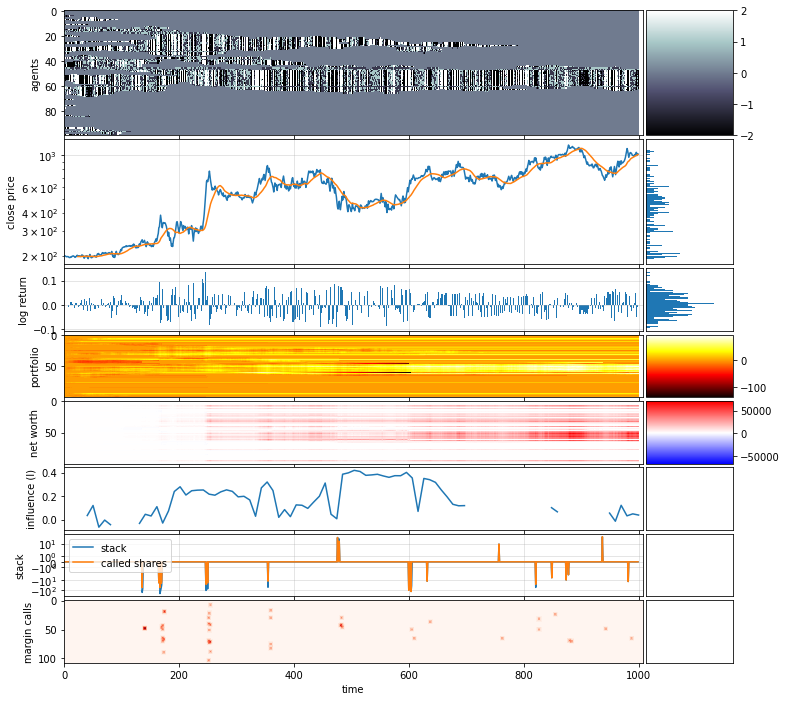

In [103]:
G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
    trigger = False, bound = False, pd = 0.025, pe = 0,
    ph = 0.03, pa = 0.4, N0=1000, N1=100, A = 4, a=1, h=1, 
    pi1 = 0.8, pi2 = 0.1, pi3 = 0.1, ub=1000, lb=20)

visualiseNICE(G, P, N, S, X, D, T, U, C)

TODO
- correlation / mutual information between clusters at time t, for each node over period t, for each cluster over period t, ...

<AxesSubplot:>

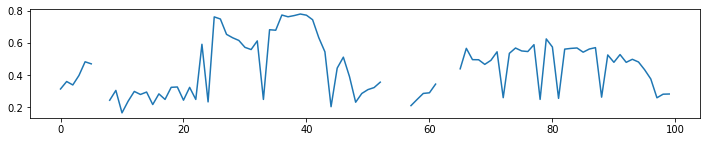